# generate training data

In [1]:
from __future__ import print_function
from trainingData import *
import os

/home/amandap/DeepCell/keras_version/tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.


In [2]:
direc_name = '/home/amandap/data/deepCellData/training'
imgs_dir = os.path.join(direc_name, 'imgs')
masks_dir = os.path.join(direc_name, 'masks')
feature_names = ['seg']
channel_names = ['img']
window_x = 30
window_y = 30
max_direcs = 250
max_training_examples = 1*10**6
file_name_save = os.path.join(direc_name, 'imgs.npz')

In [3]:
print("Loading channel data...")
channels = load_channel_imgs(imgs_dir, channel_names, window_x, window_y, max_direcs)

Loading channel data...


In [4]:
print("Loading feature masks...") 
feature_mask = load_feature_masks(masks_dir, feature_names, window_x, window_y, max_direcs, invert=False)

Loading feature masks...


In [5]:
def feature_mask_clean(feature_mask):
    pos_planes = np.array([batch.sum() for batch in feature_mask[:,0,:,:]])
    idx = pos_planes > 0
    return feature_mask[idx,:,:,:].astype('bool'), idx 

In [6]:
feature_mask, idx = feature_mask_clean(feature_mask)
channels = channels[idx,:,:,:]

In [7]:
channels[1,0,:,:].size

262144

In [3]:
import skimage
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_context("poster")

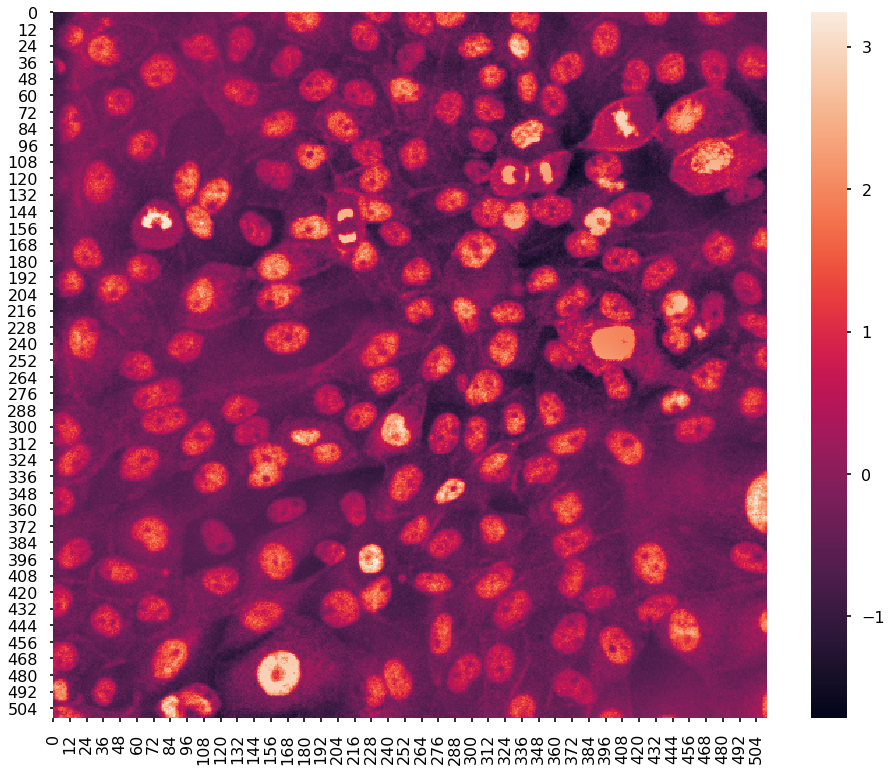

In [34]:
plt.figure(figsize=(16,13))
sns.heatmap(channels[15,0,:,:])

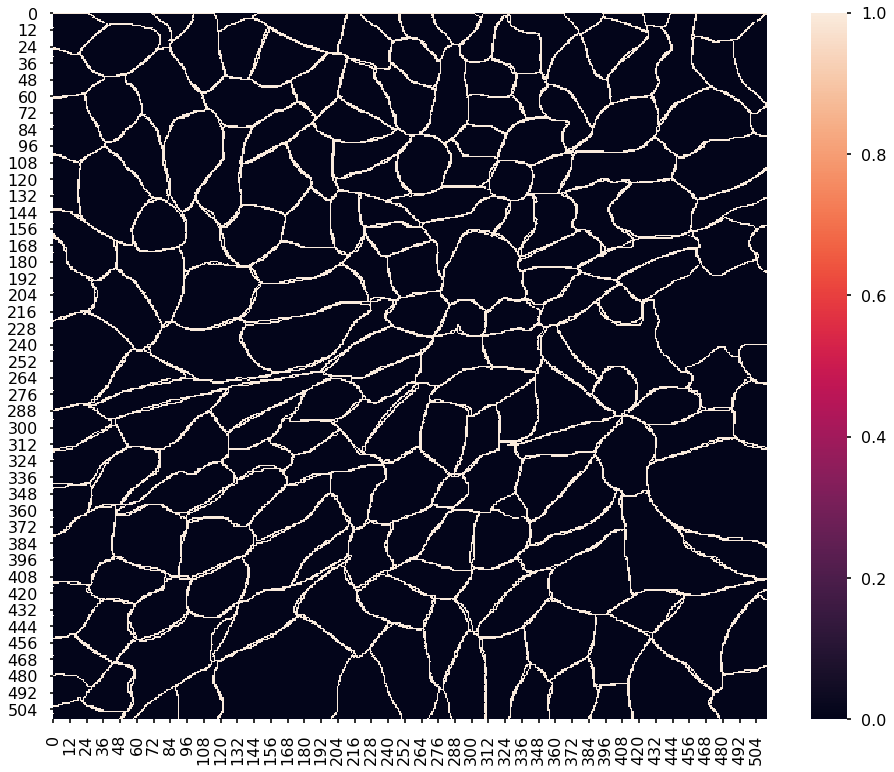

In [35]:
plt.figure(figsize=(16,13))
sns.heatmap(feature_mask[15,0,:,:])

In [36]:
print("Identifying training pixels...")
min_num = determine_min_examples(feature_mask, window_x, window_y)
print(min_num)

Identifying training pixels...
190046


In [70]:
feature_matrix = identify_training_pixels(feature_mask, min_num, window_x, window_y, max_training_examples)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [56]:
feature_mask.shape

(16, 2, 512, 512)

In [62]:
feature_matrix.shape

(4, 380092)

In [69]:
feature_matrix[0:7,380000:380007]

array([[129, 219, 196, 302, 215, 432,  73],
       [291,  88, 435, 409, 266, 371,  82],
       [  1,  11,   0,  10,   1,   3,   2],
       [  1,   1,   1,   1,   1,   1,   1]], dtype=int32)

In [71]:
print("Saving training data to :" + file_name_save)
save_training_data(file_name_save, channels, feature_matrix, window_x, window_y)

Saving training data to :/home/amandap/data/deepCellData/training/imgs.npz


# train CNN

In [38]:
from __future__ import print_function
from keras.optimizers import SGD, RMSprop
from keras.callbacks import EarlyStopping

from cnn_functions import rate_scheduler, train_model_sample
from model_zoo import bn_feature_net_61x61 as the_model

import os
import datetime
import numpy as np

In [39]:
# define a batch size and the number of epochs to run
batch_size = 512
n_epoch = 30

In [40]:
# specify names of training set and directory to save model
dataset = "imgs"
expt = "20171116_at22LA_61x61"

In [41]:
direc_save = "/home/amandap/DeepCell/trained_networks/"
direc_data = "/home/amandap/data/deepCellData/training/"

In [42]:
# Set the optimizer
# SGD works best for batchnorm nets, while RMSprop seems to be better
# for non-normalized nets

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr = 0.01, decay = 0.95)

In [46]:
for iterate in range(0,2):

    model = the_model(n_features = 2, n_channels = 1,  reg = 1e-5)

    train_model_sample(model = model, dataset = dataset, optimizer = optimizer,
        expt = expt, it = iterate, batch_size = batch_size, n_epoch = n_epoch,
        direc_save = direc_save,
        direc_data = direc_data,
        lr_sched = lr_sched,
        rotate = True, flip = True, shear = False, early_stopping=False)

    del model
    # reset the keras numbering scheme to ensure layers are named properly
    # when training >1 model in a run
    from keras.backend.common import _UID_PREFIXES
    for key in _UID_PREFIXES.keys():
        _UID_PREFIXES[key] = 0

Using feature net 61x61 with batch normalization


/home/amandap/DeepCell/keras_version/model_zoo.py:482: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(1, 61, 61..., padding="valid", kernel_initializer="he_normal")`
  model.add(Convolution2D(64, 3, 3, init = init, border_mode='valid', input_shape=(n_channels, 61, 61), W_regularizer = l2(reg)))


ValueError: negative dimensions are not allowed

In [47]:
training_data = np.load('/home/amandap/data/deepCellData/training/imgs.npz')

In [48]:
    channels = training_data["channels"]
    batch = training_data["batch"]
    labels = training_data["y"]
    pixels_x = training_data["pixels_x"]
    pixels_y = training_data["pixels_y"]
    win_x = training_data["win_x"]
    win_y = training_data["win_y"]

In [52]:
batch.size

380092

# plot training

In [15]:
loss_file='DeepCell/trained_networks/2017-11-17_imgs_20171117_at22LA_bn61x61_0.npz'

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_loss_dict(loss_file):
    ll = np.load(loss_file)
    l = ll['loss_history']
    loss = l.any()

    return loss

def plot_accuracy(loss, save_name=None, exp_name=None):
    plt.plot(loss['acc'])
    plt.plot(loss['val_acc'])
    plt.title('Model Accuracy')
    if exp_name:
        plt.suptitle(exp_name)
    plt.ylabel('Classification Accuracy')
    plt.xlabel('Training Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    if save_name:
        plt.savefig(save_name)

def plot_loss(loss, save_name=None, exp_name=None):
    plt.plot(loss['loss'])
    plt.plot(loss['val_loss'])
    plt.title('Model Loss')
    if exp_name:
        plt.suptitle(exp_name)
    plt.ylabel('Loss')
    plt.xlabel('Training Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    if save_name:
        plt.savefig(save_name)

In [16]:
loss=get_loss_dict(loss_file)

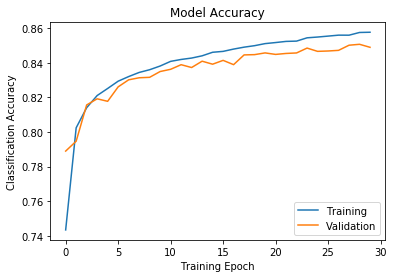

In [17]:
plot_accuracy(loss)

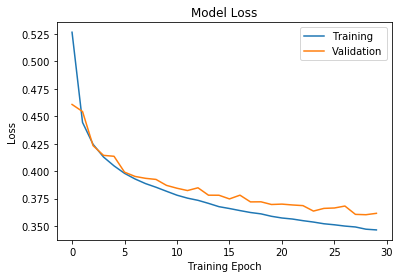

In [18]:
plot_loss(loss)

In [19]:
loss_file='DeepCell/trained_networks/2017-11-18_imgs_20171117_at22LA_bn61x61_1.npz'

In [20]:
loss=get_loss_dict(loss_file)

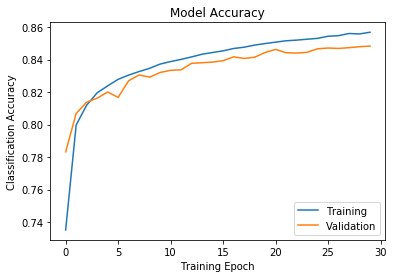

In [21]:
plot_accuracy(loss)

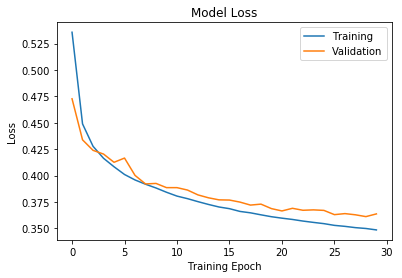

In [22]:
plot_loss(loss)

In [4]:
import skimage as im

In [5]:
ex=plt.imread('/home/amandap/data/deepCellData/validation/seged/feature_1_frame_1.png')

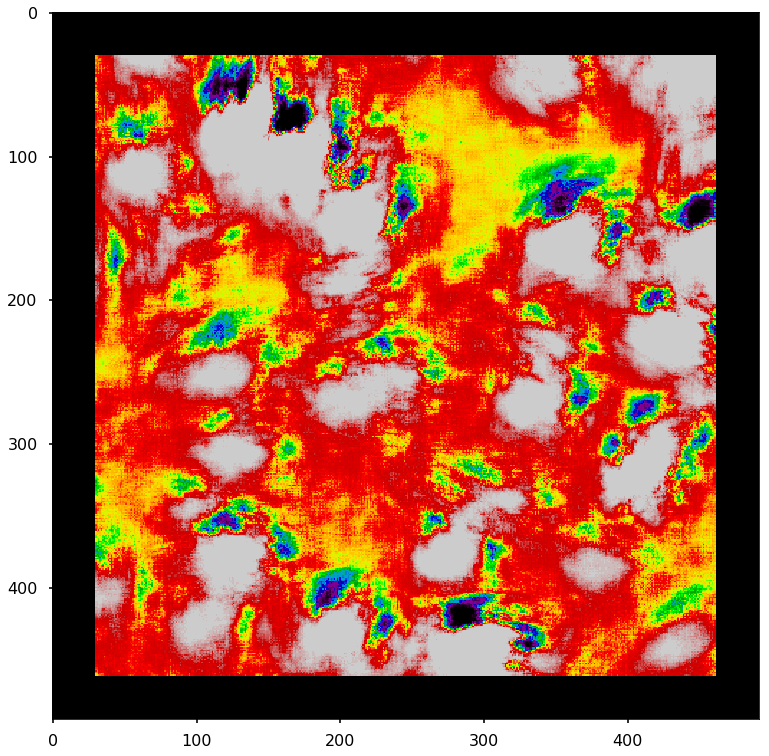

In [6]:
plt.figure(figsize=(16,13))
plt.imshow(ex, cmap="nipy_spectral")

In [7]:
img=plt.imread('/home/amandap/data/deepCellData/validation/imgs/m05s01img02.tif')

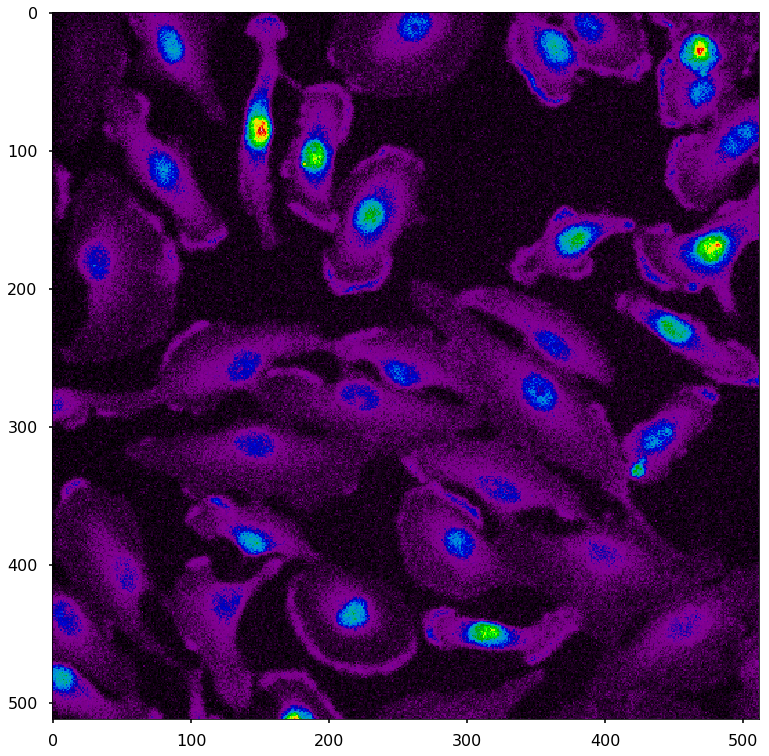

In [8]:
plt.figure(figsize=(16,13))
plt.imshow(img, cmap='nipy_spectral')

In [9]:
mask=plt.imread('/home/amandap/data/deepCellData/validation/masks/m05s01seg02.tif')

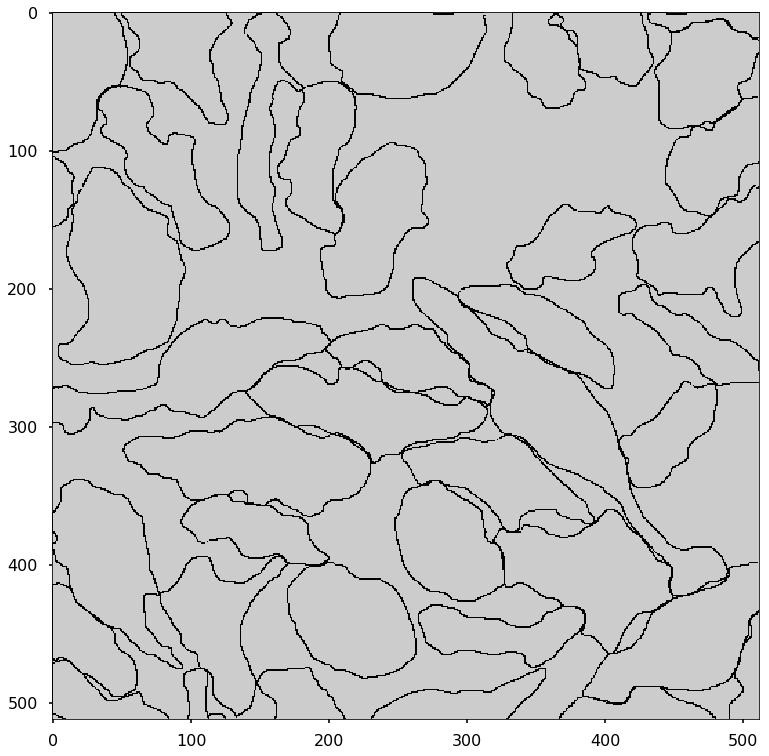

In [10]:
plt.figure(figsize=(16,13))
plt.imshow(mask, cmap='nipy_spectral')

In [52]:
import scipy as sp
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

2361.07134247
[[ 607  474  966 1276  554]
 [1430  745  910  826  941]
 [ 768  726  796 1061  661]
 [ 611 1098  608  502  714]
 [ 545 1018 1082  968  749]]
0.0
[[-1754.07134247 -1887.07134247 -1395.07134247 -1085.07134247
  -1807.07134247]
 [ -931.07134247 -1616.07134247 -1451.07134247 -1535.07134247
  -1420.07134247]
 [-1593.07134247 -1635.07134247 -1565.07134247 -1300.07134247
  -1700.07134247]
 [-1750.07134247 -1263.07134247 -1753.07134247 -1859.07134247
  -1647.07134247]
 [-1816.07134247 -1343.07134247 -1279.07134247 -1393.07134247
  -1612.07134247]]
-0.726564746189


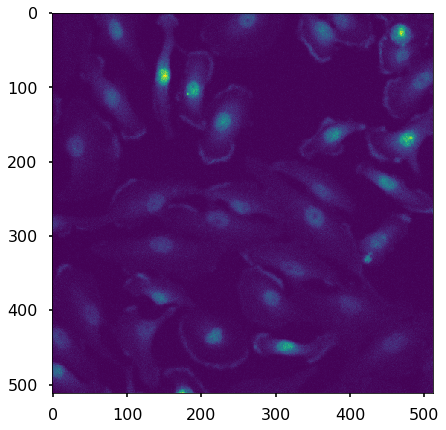

In [113]:
plt.figure(figsize=(7,7))
plt.imshow(pix)

pix = np.array(img)
print(pix.mean())
print(pix[0:5,0:5])
pix_cent = pix-pix.mean()
print(pix_cent.mean())
print(pix_cent[0:5,0:5])

scaling = MinMaxScaler(feature_range=(-1,1)).fit(pix_cent)
pix_norm = scaling.transform(pix_cent)

print(pix_norm.mean())

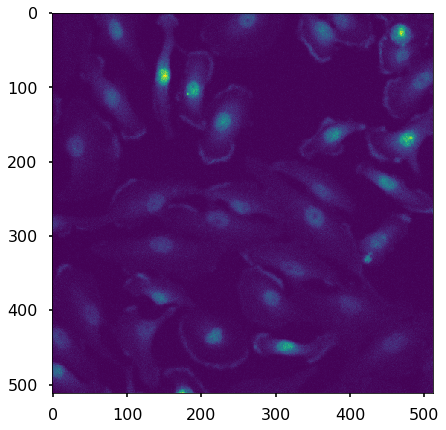

In [118]:
plt.figure(figsize=(10,7))
plt.imshow(pix_cent)

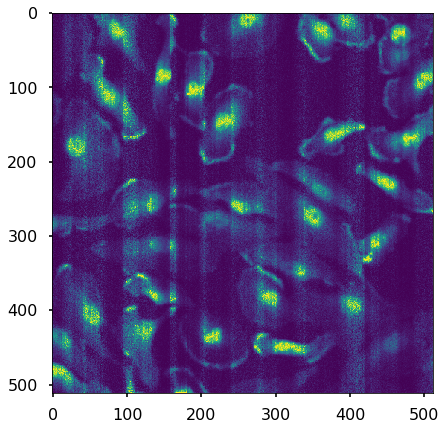

In [117]:
plt.figure(figsize=(10,7))
plt.imshow(pix_norm)

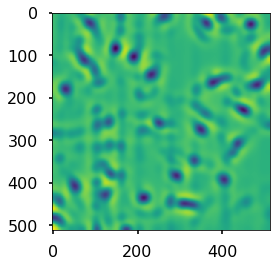

In [110]:
LoG = nd.gaussian_laplace(pix_norm, 10)
plt.imshow(LoG)

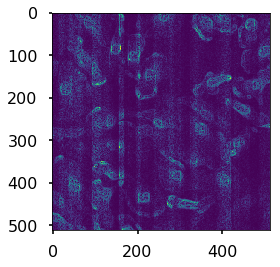

In [111]:
sobl=filters.sobel(pix_norm)
plt.imshow(sobl)

[[ 0.00808926  0.0131437   0.        ]
 [ 0.00665778  0.00462462  0.        ]
 [ 0.          0.          0.        ]] 0.00462461816493 0.0131436950074 0.0


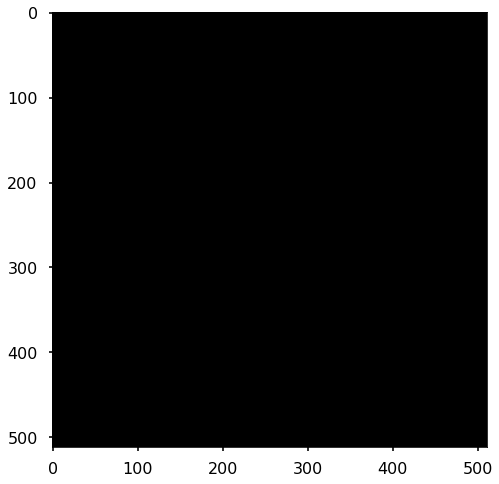

In [76]:
thres = np.absolute(sobl).mean() * 0.75
output = sp.zeros(sobl.shape)
w = output.shape[1]
h = output.shape[0]

for y in range(1, h - 1):
    for x in range(1, w - 1):
        patch = sobl[y-1:y+2, x-1:x+2]
        p = sobl[y, x]
        maxP = patch.max()
        minP = patch.min()
        if (p > 0):
            zeroCross = True if minP < 0 else False
        else:
            zeroCross = True if maxP > 0 else False
        if ((maxP - minP) > thres) and zeroCross:
            output[y, x] = 1
plt.figure(figsize=(16, 8))
print(patch, p, maxP, minP)
plt.imshow(output, cmap='nipy_spectral')
plt.show()

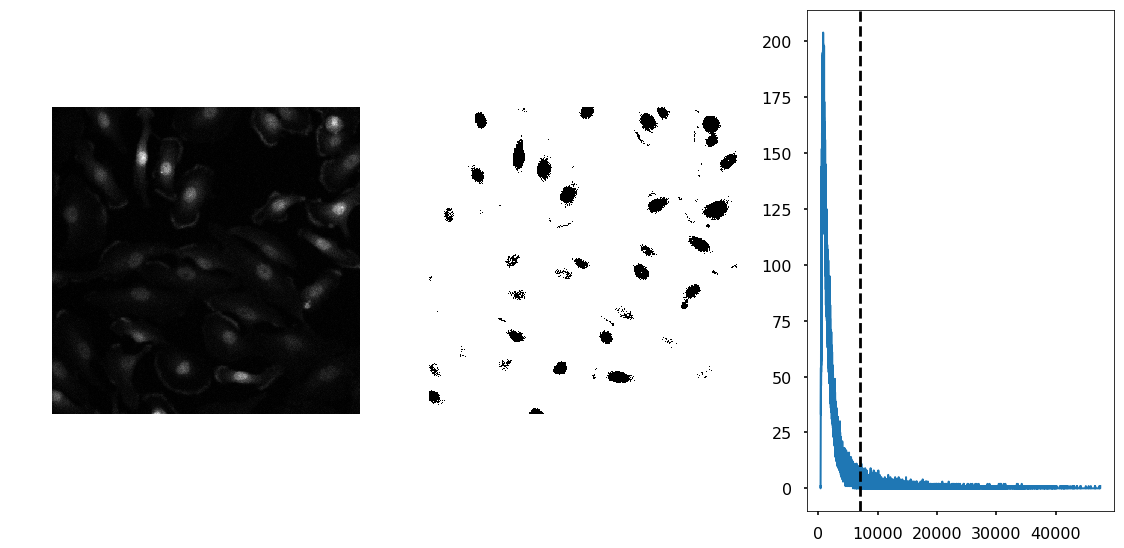

In [62]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage import exposure

val = filters.threshold_otsu(img)

hist, bins_center = exposure.histogram(img)

plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(img < val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()